In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pptoolbox.platform import preprocess, WAVELENGTHS_3NM_V1
from pptoolbox.platform.automl_v4 import AutoML_v4
from pptoolbox.platform.automl_v4.utils import cross_group_predict
from pptoolbox.platform.automl_v4.loss_functions import *
from pptoolbox.platform.automl_v4.stop_functions import stopping_criteria

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedGroupKFold, GroupKFold
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, f1_score

import pickle as pkl
from pathlib import Path

import sys

# import data

In [2]:
datasets = {
    'full': {},
    'nondeo': {}
}

pulldate = "250218"

In [3]:
for dataset in datasets:
    print(f'Processing {dataset} dataset')

    save_dir = f"../data/processed/{dataset}"

    X_train = pd.read_csv(f'{save_dir}/Xtrain.csv', index_col=0)
    X_test = pd.read_csv(f'{save_dir}/Xtest.csv', index_col=0)
    y_train = pd.read_csv(f'{save_dir}/ytrain.csv', index_col=0)
    y_test = pd.read_csv(f'{save_dir}/ytest.csv', index_col=0)

    datasets[dataset]['X_train'] = X_train
    datasets[dataset]['X_test'] = X_test
    datasets[dataset]['y_train'] = y_train
    datasets[dataset]['y_test'] = y_test

    print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
    print(f'X_test: {X_test.shape}, y_test: {y_test.shape}')
    print()

Processing full dataset
X_train: (3024, 191), y_train: (3024, 20)
X_test: (763, 191), y_test: (763, 20)

Processing nondeo dataset
X_train: (2004, 191), y_train: (2004, 19)
X_test: (545, 191), y_test: (545, 19)



# Train Profile

In [4]:
for dataset in datasets:
    print(f'Processing {dataset} dataset')
    X_train = datasets[dataset]['X_train']
    y_train = datasets[dataset]['y_train']

    for col in y_train.columns:
        if y_train[col].dtype != 'float64':
            # print(f'{col} is not a float64 column, skipping')
            continue
        print(f'Training model for {col}')

        # display(y_train[col])

        # continue
        
        output_dir = Path(f"../models/automl/{dataset}/{col}")
        output_dir.mkdir(parents=True, exist_ok=True)
        selected_y_train = y_train[col]

        # check if model exists
        if (output_dir / "trainer.pkl").exists():
            print("Model exists, skipping training")
        else:
            trainer = AutoML_v4(
                task_type = "profile", 
                loss_fn = add_timeout(loss_function, timeout = 30),
                stop_fn = stopping_criteria,
                exploration = 50,
                exploitation = 150,
                stagnant_runs = 50,
            )
            trainer.fit(X_train, selected_y_train)
            pkl.dump(trainer, open(
                output_dir / "trainer.pkl", "wb"
            )
            )
    print()

Processing full dataset
Training model for Sensory Value
 60%|██████    | 121/200 [07:47<05:05,  3.87s/trial, best loss: 0.1410789765432172]

Processing nondeo dataset
Training model for Sensory Value
100%|██████████| 200/200 [07:27<00:00,  2.24s/trial, best loss: 0.15285751468854694]



# inspect trainer

In [6]:
# inspect trainer
for dataset in datasets:
    print(f'Loading {dataset} trainer')
    for col in datasets[dataset]['y_train'].columns:
        if datasets[dataset]['y_train'][col].dtype != 'float64':
            # print(f'{col} is not a float64 column, skipping')
            continue
        print(f'Inspecting model for {col}')
        
        output_dir = Path(f"../models/automl/{dataset}/{col}")
        trainer = pkl.load(open(output_dir / "trainer.pkl", "rb"))
        display(trainer.get_pipeline())
    print()

Loading full trainer
Inspecting model for Sensory Value


Pipeline(steps=[('SG1D7W', SavitzkyGolay(deriv=1, window=7)),
                ('Scaler', StandardScaler(with_std=False)),
                ('SVR', SVR(C=0.30309102498693963, cache_size=2000))])


Loading nondeo trainer
Inspecting model for Sensory Value


Pipeline(steps=[('SG1D19W', SavitzkyGolay(deriv=1, window=19)),
                ('Scaler', StandardScaler(with_std=False)),
                ('SVR', SVR(C=0.25961265014275486, cache_size=2000))])

# combined metrics

In [ ]:
for dataset in datasets:
    for param in params:
        cleaned_input = datasets[dataset]['cleaned_input']
        cleaned_label = datasets[dataset]['cleaned_label'][[param, 'batch']]
        
        # Train Data
        train_label = cleaned_label[cleaned_label['batch'].str.contains('train')]
        train_input = cleaned_input.loc[train_label.reset_index().drop_duplicates().set_index('lot_id').index]

        # Validation Data
        val_label = cleaned_label[cleaned_label['batch'].str.contains('val')].drop(columns=['batch'])
        val_input = cleaned_input.loc[val_label.reset_index().drop_duplicates().set_index('lot_id').index]

        grouped_val_label = val_label.reset_index().groupby('lot_id').mean()
        grouped_val_input = val_input.reset_index().groupby('lot_id').mean()

        # Create subplots: Train (1st row) and Validation (2nd row)
        num_models = len(models)
        num_cfm = 2  # Train and Validation

        fig, axes = plt.subplots(num_cfm, num_models, figsize=(num_cfm*5, num_models*5), sharex=True, sharey=True)
        fig.suptitle(f'Predicted vs Actual for {param}', fontsize=14)

        for col, model in enumerate(models):  # Loop over models
            trainer = models[model][param]
            model_name = models[model]['id']

            if models[model]['id'] == 'AJC clear Model 70 lots':
                train_label_temp = train_label.copy()
                train_label_temp = train_label_temp.drop(columns=['batch'])
                train_input_temp = train_input.loc[train_label_temp.reset_index().drop_duplicates().set_index('lot_id').index]

            elif models[model]['id'] == 'AJC clear Model 50 lots':
                train_label_temp = train_label.copy()
                train_label_temp = train_label[~train_label_temp['batch'].str.contains('70')].drop(columns=['batch'])
                train_input_temp = train_input.loc[train_label_temp.reset_index().drop_duplicates().set_index('lot_id').index]

            grouped_train_label = train_label_temp.reset_index().groupby('lot_id').mean()
            training_range = train_label_temp.values.max() - train_label_temp.values.min()

            # --- TRAIN PREDICTIONS ---
            train_pred = cross_group_predict(
                trainer.get_pipeline(),
                X = train_input_temp,
                y = train_label_temp[param],
                cv = GroupKFold(n_splits=3),
                groups = train_label_temp.index,
            )
        
            train_pred = pd.DataFrame(train_pred, index=grouped_train_label.index, columns=[param])

            # Calculate MAE for training
            train_mae = np.mean(np.abs(grouped_train_label - train_pred))[0]
            train_pmae = train_mae / training_range * 100

            # --- VALIDATION PREDICTIONS ---
            val_pred = trainer.get_pipeline().predict(grouped_val_input).ravel()
            val_pred = pd.DataFrame(val_pred, index=grouped_val_input.index, columns=[param])

            # Calculate MAE for validation
            val_mae = np.mean(np.abs(grouped_val_label - val_pred))[0]
            val_pmae = val_mae / training_range * 100

            # Plotting

            label_max = np.max([train_label[param].values.max(), train_pred.values.max(), grouped_val_label[param].values.max(), val_pred.values.max()])
            label_min = np.min([train_label[param].values.min(), train_pred.values.min(), grouped_val_label[param].values.max(), val_pred.values.min()])
            label_range = label_max - label_min
            label_start = label_min - 0.1*label_range
            label_end = label_max + 0.1*label_range

            ax = axes[0, col]  # Train row, column based on model order

            sns.scatterplot(x=grouped_train_label.values.ravel(), 
                            y=train_pred.values.ravel(), 
                            color='blue', alpha=0.5, ax=ax)
            
            ax.set_xlim(label_start, label_end)
            ax.set_ylim(label_start, label_end)

            ax.plot([label_start, label_end], 
                    [label_start, label_end], 
                    color='black', linestyle='--')

            ax.set_title(f'{model_name} | Train\nMAE: {train_mae:.2f} | Range: {training_range:.2f} | pMAE: {train_pmae:.2f}%')
            ax.set_xlabel('Actual')
            ax.set_ylabel('Predicted')

            ax = axes[1, col]  # Validation row, column based on model order

            sns.scatterplot(x=grouped_val_label.values.ravel(), 
                            y=val_pred.values.ravel(), 
                            color='red', alpha=0.5, ax=ax)
            
            ax.set_xlim(label_start, label_end)
            ax.set_ylim(label_start, label_end)

            ax.plot([label_start, label_end], 
                    [label_start, label_end], 
                    color='black', linestyle='--')

            ax.set_title(f'{model_name} | Validation\nMAE: {val_mae:.2f} | Trng Range: {training_range:.2f} | pMAE: {val_pmae:.2f}%')
            ax.set_xlabel('Actual')
            ax.set_ylabel('Predicted')
            
        plt.show()


# training metrics

Processing full dataset
Evaluating model for Sensory Value


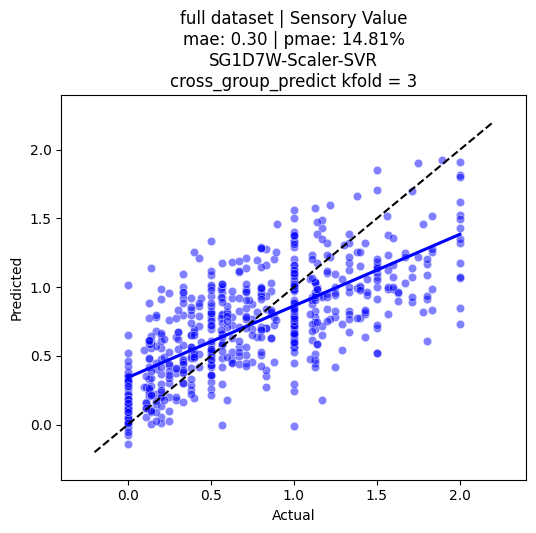

Processing nondeo dataset
Evaluating model for Sensory Value


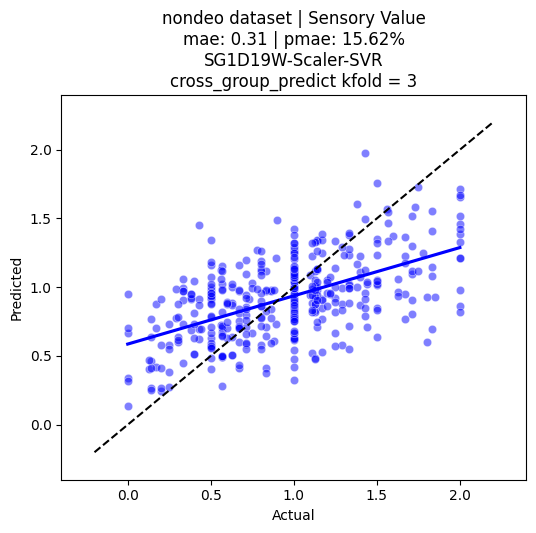

In [10]:
for dataset in datasets:
    print(f'Processing {dataset} dataset')
    X_train = datasets[dataset]['X_train']
    y_train = datasets[dataset]['y_train']

    for col in y_train.select_dtypes(include=['float64']).columns:
        print(f'Evaluating model for {col}')
        output_dir = Path(f"../models/automl/{dataset}/{col}")

        X_input = X_train
        y_input = y_train[col]

        y_list = list(y_input)

        trainer = pkl.load(open(output_dir / "trainer.pkl", "rb"))

        grouped_y = y_input.groupby(y_input.index).apply(lambda x: x.iloc[0])

        k = 3
        metric_kfold = GroupKFold(n_splits = k)

        predictions = cross_group_predict(
            trainer.get_pipeline(),
            X = X_input,
            y = y_input,
            cv = metric_kfold, 
            groups = y_input.index
        )

        mae_range = abs(grouped_y.max() - grouped_y.min())
        mae = np.mean(np.abs(predictions - grouped_y))
        max_error = np.max(np.abs(predictions - grouped_y))
        pmae = (mae * 100) / mae_range
        pmae_full = (mae * 100) / 8 # update this value

        plt.figure(figsize=(6, 5))
        plt.xlim(grouped_y.min()-grouped_y.max()*.2, grouped_y.max()+grouped_y.max()*.2)
        plt.ylim(grouped_y.min()-grouped_y.max()*.2, grouped_y.max()+grouped_y.max()*.2)
        sns.scatterplot(x=grouped_y, y=predictions, color='blue', alpha=0.5)
        sns.regplot(x=grouped_y, y=predictions, scatter=False, color='blue', ci=None)
        plt.plot([grouped_y.min()-grouped_y.max()*.1, grouped_y.max()+grouped_y.max()*.1], 
                [grouped_y.min()-grouped_y.max()*.1, grouped_y.max()+grouped_y.max()*.1], 
                color='black', linestyle='--')  # Reference line
        plt.title(f'{dataset} dataset | {col}\nmae: {float(mae):.2f} | pmae: {float(pmae):.2f}%\n{trainer.get_pipeline_name()}\ncross_group_predict kfold = {k}')
        plt.xlabel(f'Actual')
        plt.ylabel(f'Predicted')
        plt.savefig(output_dir / f'prederror_{col}_best.png', bbox_inches='tight')

        plt.show()
        plt.close()

Processing full dataset
Evaluating model for Sensory Value
Processing nondeo dataset
Evaluating model for Sensory Value


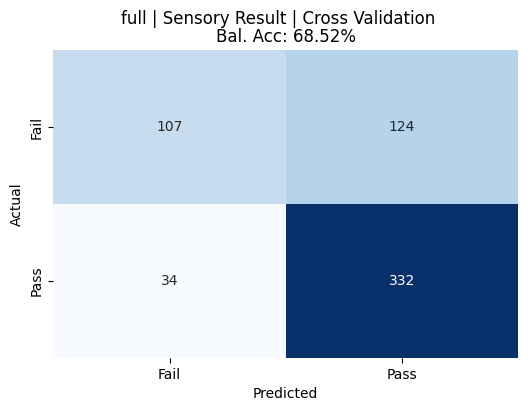

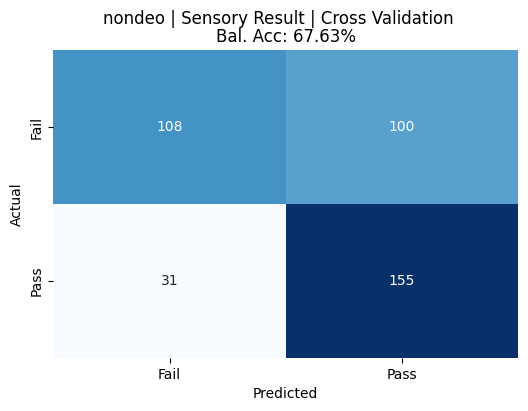

In [56]:
for dataset in datasets:
    print(f'Processing {dataset} dataset')
    X_train = datasets[dataset]['X_train']
    y_train = datasets[dataset]['y_train']

    for col in y_train.select_dtypes(include=['float64']).columns:
        print(f'Evaluating model for {col}')
        output_dir = Path(f"../models/automl/{dataset}/{col}")

        X_input = X_train
        y_input = y_train[col]

        y_list = list(y_input)

        trainer = pkl.load(open(output_dir / "trainer.pkl", "rb"))

        grouped_y = y_input.groupby(y_input.index).apply(lambda x: x.iloc[0])

        k = 3
        metric_kfold = GroupKFold(n_splits = k)

        predictions = cross_group_predict(
            trainer.get_pipeline(),
            X = X_input,
            y = y_input,
            cv = metric_kfold, 
            groups = y_input.index
        )


        sensory_result_df = pd.read_csv('../data/processed/label_250218.csv')
        sensory_result_df = sensory_result_df.set_index('lot_id')['Sensory Result']
        sensory_result_df = sensory_result_df.loc[datasets[dataset]['y_train'].index.unique()]

        comparison_df = pd.concat([predictions, sensory_result_df], axis=1)
        comparison_df.columns = ['predicted_value', 'actual']
        comparison_df['predicted'] = np.where(comparison_df['predicted_value'] > 1, "Fail", "Pass")

        cnfm = confusion_matrix(comparison_df['actual'], comparison_df['predicted'])
        bal_acc = balanced_accuracy_score(comparison_df['actual'], comparison_df['predicted'])

        fig = plt.figure(figsize = (6, 4))
        fig.suptitle(f"{dataset} | Sensory Result | Cross Validation")
        ax = fig.add_subplot(111)

        ax.set_title(f"Bal. Acc: {bal_acc*100:.2f}%")

        cnfm_settings = {
            "cmap": "Blues",
            "cbar": None,
            "annot": True,
            "fmt": ".0f",
            "xticklabels": ['Fail', 'Pass'],
            "yticklabels": ['Fail', 'Pass']
        }

        sns.heatmap(
            cnfm,
            ax = ax,
            **cnfm_settings
        )

        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')

# blinds predict

Processing full dataset
Evaluating model for Sensory Value


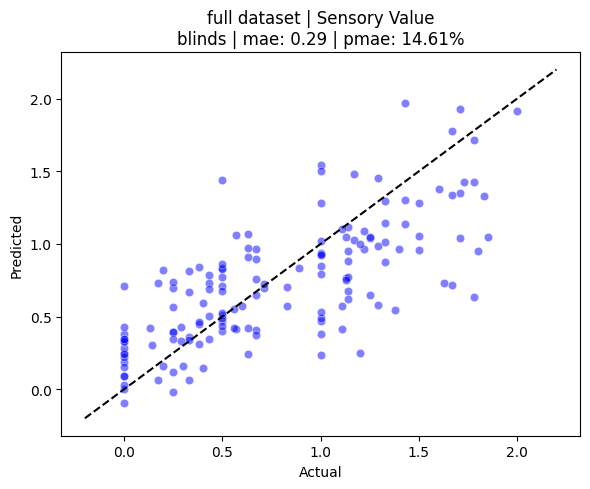

Processing nondeo dataset
Evaluating model for Sensory Value


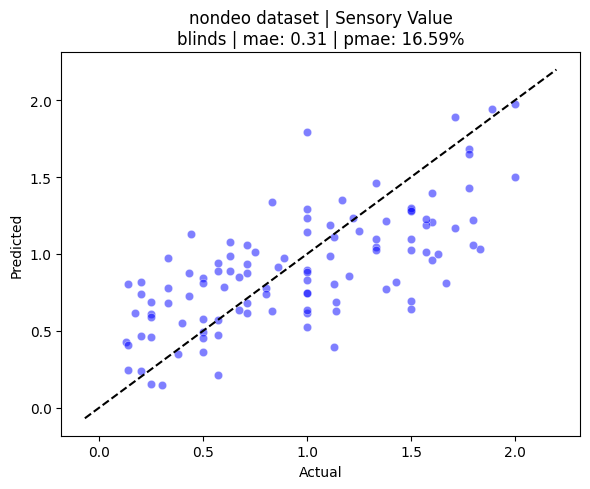

In [48]:
for dataset in datasets:
    print(f'Processing {dataset} dataset')
    X_test = datasets[dataset]['X_test']
    y_test = datasets[dataset]['y_test']

    for col in y_test.select_dtypes(include=['float64']).columns:
        print(f'Evaluating model for {col}')
        output_dir = Path(f"../models/automl/{dataset}/{col}")

        X_input = X_test.groupby(X_test.index).mean()
        y_input = y_test[col].groupby(y_test.index).mean()

        y_list = list(y_input.values.ravel())

        trainer = pkl.load(open(output_dir / "trainer.pkl", "rb"))

        predictions = pd.DataFrame(trainer.predict(X_input))

        blinds_MAE = np.mean(np.abs(y_input.values - predictions[0].values))
        blinds_pMAE = (blinds_MAE * 100) / abs(y_input.max()-y_input.min())

        plt.figure(figsize=(6, 5))
        sns.scatterplot(x=y_list, y=predictions[0], color='blue', alpha=0.5)
        plt.plot([y_input.min()-y_input.max()*.1, y_input.max()+y_input.max()*.1], 
                [y_input.min()-y_input.max()*.1, y_input.max()+y_input.max()*.1], 
                color='black', linestyle='--')  # Reference line
        plt.title(f'{dataset} dataset | {col}\nblinds | mae: {blinds_MAE:.2f} | pmae: {blinds_pMAE:.2f}%')

        plt.xlabel(f'Actual')
        plt.ylabel(f'Predicted')
        plt.tight_layout()
        plt.savefig(output_dir / f'prederror_{col}_blind.png', bbox_inches='tight')

        plt.show()
        plt.close()

Processing full dataset
Evaluating model for Sensory Value
Processing nondeo dataset
Evaluating model for Sensory Value


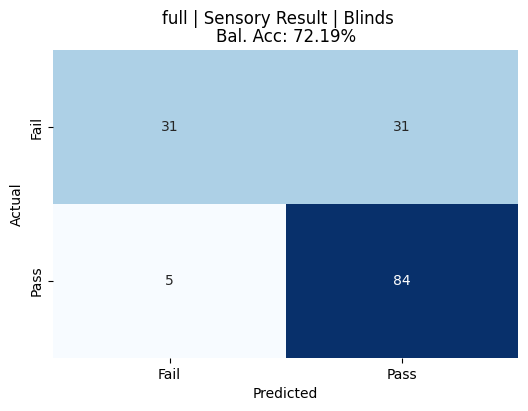

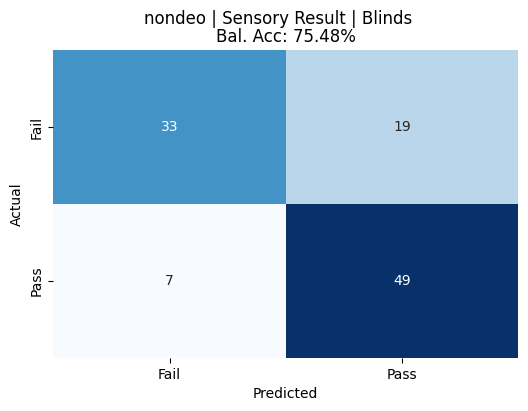

In [58]:
for dataset in datasets:
    print(f'Processing {dataset} dataset')
    X_test = datasets[dataset]['X_test']
    y_test = datasets[dataset]['y_test']

    for col in y_test.select_dtypes(include=['float64']).columns:
        print(f'Evaluating model for {col}')
        output_dir = Path(f"../models/automl/{dataset}/{col}")

        X_input = X_test.groupby(X_test.index).mean()
        y_input = y_test[col].groupby(y_test.index).mean()

        y_list = list(y_input.values.ravel())

        trainer = pkl.load(open(output_dir / "trainer.pkl", "rb"))

        predictions = pd.Series(trainer.predict(X_input), index=X_input.index)

        sensory_result_df = pd.read_csv('../data/processed/label_250218.csv')
        sensory_result_df = sensory_result_df.set_index('lot_id')['Sensory Result']
        sensory_result_df = sensory_result_df.loc[datasets[dataset]['y_test'].index.unique()]

        comparison_df = pd.concat([predictions, sensory_result_df], axis=1)
        comparison_df.columns = ['predicted_value', 'actual']
        comparison_df['predicted'] = np.where(comparison_df['predicted_value'] > 1, "Fail", "Pass")

        cnfm = confusion_matrix(comparison_df['actual'], comparison_df['predicted'])
        bal_acc = balanced_accuracy_score(comparison_df['actual'], comparison_df['predicted'])

        fig = plt.figure(figsize = (6, 4))
        fig.suptitle(f"{dataset} | Sensory Result | Blinds")
        ax = fig.add_subplot(111)

        ax.set_title(f"Bal. Acc: {bal_acc*100:.2f}%")

        cnfm_settings = {
            "cmap": "Blues",
            "cbar": None,
            "annot": True,
            "fmt": ".0f",
            "xticklabels": ['Fail', 'Pass'],
            "yticklabels": ['Fail', 'Pass']
        }

        sns.heatmap(
            cnfm,
            ax = ax,
            **cnfm_settings
        )

        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')